In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
from datetime import datetime
import os

import ipywidgets as widgets

In [2]:
titlesize = 16
labelsize = 16
legendsize = 16
xticksize = 16
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Зависимость ошибок 1-го и 2-го рода

Посмотрим, как ошибки первого и второго рода зивисят от величины эффекта и дисперсии.

$\beta = 1 - \Phi\Bigl(\dfrac{\varepsilon}{\sigma} - \Phi^{-1}~(1 - \alpha)\Bigr)$

In [3]:
x = np.linspace(-4, 6, 1001)
H0_dist = stats.norm()
H0_pdf = H0_dist.pdf(x)

def get_beta(alpha, H1_mean, H1_std=1.0, two_side=False):
    H0_dist = stats.norm()
    if two_side:
        alpha = alpha / 2

    right_bound = H0_dist.ppf(1 - alpha)
    H1_dist = stats.norm(loc=H1_mean, scale=H1_std)
    beta = H1_dist.cdf(right_bound)
    if two_side:
        beta -= H1_dist.cdf(-right_bound)
    return beta
    
def plot_first_second_type_errors(H1_mean, H1_std, alpha, two_side=True):
    H1_dist = stats.norm(loc=H1_mean, scale=H1_std)
    H1_pdf = H1_dist.pdf(x)
    plt.figure(figsize=(10, 5))
    plt.plot(x, H0_pdf, label='H0 distribution')
    plt.plot(x, H1_pdf, label='H1 distribution')

    beta = get_beta(alpha, H1_mean, H1_std, two_side=two_side)
    cr_bound = alpha / 2 if two_side else alpha
    x_left, x_right = H0_dist.ppf(cr_bound), H0_dist.ppf(1 - cr_bound)
    alpha_error_left = np.linspace(-4, x_left, 101)
    alpha_error_right = np.linspace(x_right, 6, 101)
    if two_side:
        plt.fill_between(alpha_error_left, H1_dist.pdf(alpha_error_left), color='green', alpha=0.25)
        plt.fill_between(alpha_error_left, H0_dist.pdf(alpha_error_left), color='red', alpha=0.25)
    plt.fill_between(alpha_error_right, H1_dist.pdf(alpha_error_right), color='green', alpha=0.25)
    plt.fill_between(alpha_error_right, H0_dist.pdf(alpha_error_right), color='red', alpha=0.25)

    title = f'Критические области {"двустороннего" if two_side else "одностороннего"} критерия'
    plt.title(title, size=16)
    plt.legend(loc=2, fontsize=14)
    annotation = f'alpha = {alpha:.3f}\npower = {1-beta:.3f}'
    plt.text(-4.1, 0.26, annotation, size=18)
    plt.grid()
    plt.show()

interactive_plot = widgets.interactive(
    plot_first_second_type_errors, 
    H1_mean=widgets.FloatSlider(value=2,min=0,max=6,step=0.1,description='H1 mean:'),
    H1_std=widgets.FloatSlider(value=2,min=0.5,max=2,step=0.1,description='H1 std:'),
    alpha=widgets.FloatSlider(value=0.1,min=0.01,max=0.25,step=0.01,description='alpha:'),
    two_side=True)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=2.0, description='H1 mean:', max=6.0), FloatSlider(value=2.0, descript…

# 2. Размер выборки (sample size)

Рассмотрим гипотезу о равенстве средних

$H_0: \mu_X = \mu_Y$

против альтернативной

$H_1: \mu_X \neq \mu_Y$

Напишем функцию для оценки размера выборки. Проверим на искусственных данных, что она работает корректно.

$$n > \dfrac{\left[ \Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2} \Bigr) + \Phi^{-1} \Bigl( 1-\beta \Bigr) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Реализуем эту формулу для случая равных дисперсий:

In [4]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

Часто нам интересно не абсолютное, а относительное изменение, эффект может быть посчитан как относительное увеличение среднего значения. Пересчитаем минимальный размер в этих терминах:

In [5]:
def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

In [6]:
mu = 10
std = 1
eff = 1.01
alpha = 0.05
beta = 0.2


sample_size = get_sample_size_arb(mu, std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')


print('Ошибки I и II рода:')
for _ in range(5):
    result_aa = []
    result_ab = []
    for _ in range(5000):
        a_one = np.random.normal(mu, std, sample_size)
        a_two = np.random.normal(mu, std, sample_size)
        b = np.random.normal(mu * eff, std, sample_size)
        result_aa.append(check_ttest(a_one, a_two, alpha=alpha))
        result_ab.append(check_ttest(a_one, b, alpha=alpha))
    error_first = np.mean(result_aa)
    error_second = 1 - np.mean(result_ab)
    print(f'  {error_first:0.3f} \t{error_second:0.3f}')

sample_size = 1570

Ошибки I и II рода:
  0.050 	0.196
  0.049 	0.198
  0.043 	0.209
  0.051 	0.196
  0.052 	0.192


Видно, что получаем ошибки, которые и закладывали. Функция работает корректно.

## 3. Различные сценарии
Давайте посмотрим, сколько нужно данных, чтобы отлавливать различные эффекты с различными ошибками первого и второго рода.

In [7]:
def get_table_sample_size(mu, std, effects, errors):
    results = []
    for eff in effects:
        results_eff = []
        for err in errors:
            results_eff.append(
                get_sample_size_arb(
                    mu,
                    std,
                    eff=eff,
                    alpha=err,
                    beta=err
                )
            )
        results.append(results_eff)
        
    df_results = pd.DataFrame(results)
    df_results.index = pd.MultiIndex(
        levels=[[f'{np.round((x - 1)*100, 1)}%' for x in effects]],
        codes=[np.arange(len(effects))],
        names=['effects']
    )
    df_results.columns = pd.MultiIndex.from_tuples(
        [(err, ) for err in errors],
        names=['errors']
    )
    return df_results

In [8]:
effects = np.linspace(1.01, 1.1, 10)
errors = [0.05, 0.1, 0.15, 0.2]

get_table_sample_size(10, 2, effects, errors)

errors,0.05,0.10,0.15,0.20
effects,,,,
1.0%,10396,6852,4905,3607
2.0%,2599,1713,1227,902
3.0%,1156,762,545,401
4.0%,650,429,307,226
5.0%,416,275,197,145
6.0%,289,191,137,101
7.0%,213,140,101,74
8.0%,163,108,77,57
9.0%,129,85,61,45


# 4. MDE

Напишем функцию для оценки размера выборки:

$$\varepsilon > \frac{\left[ \Phi^{-1} \left( 1-\dfrac{\alpha}{2} \right) + \Phi^{-1} \left( 1-\beta \right) \right] \sqrt{ \sigma_X^2 + \sigma_Y^2 }}{\sqrt{n}}$$

Реализуем эту формулу для случая равных дисперсий:

In [9]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

In [10]:
sample_size = 1000
mu = 0
std = 1
alpha = 0.05
beta = 0.2

mde = get_minimal_determinable_effect(
    std, sample_size, alpha=alpha, beta=beta
)
print(f'mde = {mde}\n')

print('Ошибки I и II рода:')
for _ in range(5):
    result_aa = []
    result_ab = []
    for _ in range(5000):
        a_one = np.random.normal(mu, std, sample_size)
        a_two = np.random.normal(mu, std, sample_size)
        b = np.random.normal(mu + mde, std, sample_size)
        result_aa.append(check_ttest(a_one, a_two, alpha=alpha))
        result_ab.append(check_ttest(a_one, b, alpha=alpha))

    error_first = np.mean(result_aa)
    error_second = 1 - np.mean(result_ab)
    print(f'  {error_first:0.3f} \t{error_second:0.3f}')

mde = 0.12529069984918345

Ошибки I и II рода:
  0.051 	0.206
  0.052 	0.204
  0.052 	0.193
  0.050 	0.202
  0.044 	0.195


Видно, что получаем ошибки, которые и закладывали. Функция работает корректно.

# Данные пиццерии

Наши разработчики создали новую версию бэкенда и хотят её протестировать. Новый бэкенд решает те же задачи, что и старый, поэтому улучшений во время эксперимента мы не ожидаем. Задача эксперимента — проверить, не возникнет ли проблем у пользователей, если мы заменим старую версию на новую. Например, если мы перейдём от монолитного ядра к микросервисной архитектуре. 

Одна из основных метрик бэкенда — время обработки запроса. Никто не любит, когда страницы сайта долго загружаются. Если страницы будут долго открываться, то часть пользователей перестанет заказывать пиццу на нашем сайте. 

В этом эксперименте мы будем оценивать изменение среднего времени обработки запросов. Если время обработки запроса значимо увеличится, то переход на новый бэкенд может привести к снижению выручки из-за ухода части пользователей.

Нужно разобраться, как подготовиться к запуску эксперимента и запустить A/B тест.

In [11]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [12]:
web_logs = read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date'] = pd.to_datetime(web_logs['date'])
web_logs.head(3)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7


Web-logs — таблица с логами посещения сайта.

1. user_id — идентификатор пользователя;
2. page — какая страница сайта была открыта. Типы страниц:
    + m — страница с меню;
    + b  — страница с корзиной и подтверждением заказа;
    + p — страница с оплатой заказа;
3. date — дата открытия страницы;
4. load_time — время загрузки страницы в миллисекундах.

**Предполагается, что данные независимы**

2022-02-03 23:45:37
2022-04-01 11:59:57
(1964507, 4)


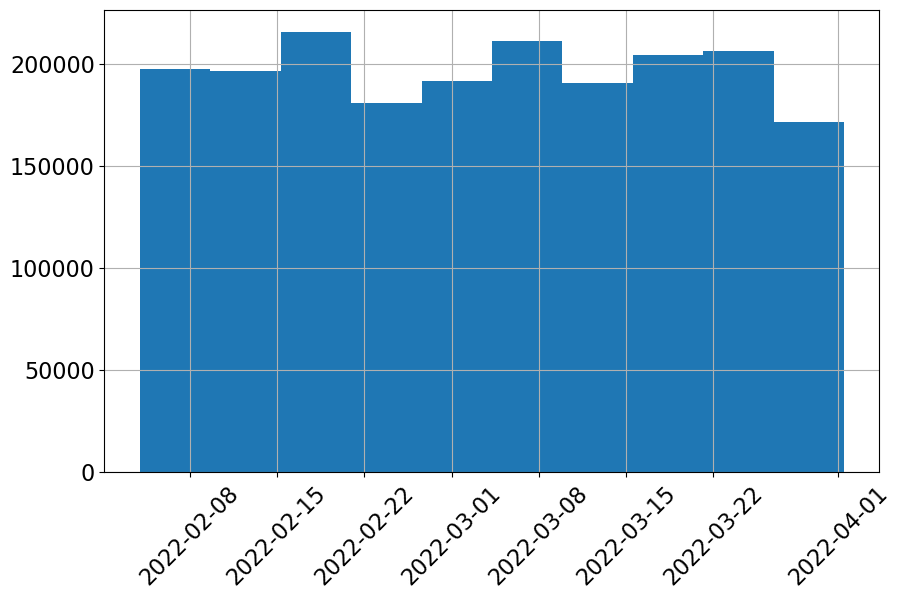

In [13]:
print(web_logs['date'].min())
print(web_logs['date'].max())
print(web_logs.shape)
web_logs['date'].hist(xrot=45);

Предположим, что мы хотим проводить тест в течение одной недели.

Для этого на историческом промежутке выберем интервал длинной в одну неделю и проведем все расчеты для данного промежутка времени. Отметим, что сегодня 1 апреля, поэтому мы взяли неделю непосредственно перед запуском эксперимента. Данный подход служит неплохой эвристикой.

In [14]:
web_logs_hist = web_logs[
    (web_logs['date'] >= datetime(2022, 3, 22))
    & (web_logs['date'] < datetime(2022, 3, 29))
]
web_logs_hist.shape

(247163, 4)

Предположим, что 1% для нас не является существенным изменением. То есть нас устроит любое изменение в пределах одного процента. Таким образом, если эффект будет равен одному проценту, мы хотим быть способны обнаружить его с большой вероятностью.

Зафиксируем параметры эксперимента и посчитаем необходимые статистики.

In [15]:
alpha = 0.05
beta = 0.2
eff = 1.01

mean = web_logs_hist['load_time'].mean()
std = web_logs_hist['load_time'].std()

Оценим размер выборки в одной группе (контрольной или экспериментальной)

In [16]:
sample_size = get_sample_size_abs(mean / 100, std, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = get_sample_size_arb(mean, std, eff=eff, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 355889
sample_size = 355889


Для проведения эксперимента нам требуется 700 000 наблюдений в течение недели. А всего у нас 247000 наблюдений за неделю до эксперимента.

Давайте попробуем решить обратную задачу. А какой эффект мы бы смогли обнаружить, проведи мы эксперимент на данной неделе, разбив всех пользователей на две группы?

In [ ]:
mde = get_minimal_determinable_effect(std, web_logs_hist.shape[0] // 2, alpha=alpha, beta=beta)
print(f'mde = {np.round(mde, 3)}')
print(f'mde = {np.round(mde / mean * 100, 3)}%')

Хотим 1%, а можем 1.7%. В будущем мы научимся увеличивать чувствительность тестов с помощью различных техник, а сейчас давайте предположим, что нас устроит чувствительность 3%. То есть мы считаем, что эффект менее 3% для нас незначителен.

Давайте оценим, сколько загрузок страниц нам потребуется для оценки эксперимента.

In [ ]:
alpha = 0.05
beta = 0.2
eff = 1.03

mean = web_logs_hist['load_time'].mean()
std = web_logs_hist['load_time'].std()

sample_size = get_sample_size_arb(mean, std, eff=eff, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

Таким образом, в каждую группу требуется выделить 40000 событий, связанных с загрузкой страницы, чтобы мы были способны отловить эффект 3% на уровне значимости 0.05 и мощностью 0.8.

Но эксперимент мы будем проводить на клиентах, поэтому давайте посчитаем, сколько клиентов требуется выделить в каждую группу. Для этого посчитаем, сколько в среднем каждый клиент делает сессий в течение недели.

In [ ]:
ratio = web_logs_hist.groupby(['user_id'])['load_time'].count().mean()
print(ratio)

ratio = web_logs_hist.shape[0] / web_logs_hist['user_id'].nunique()
print(ratio)

In [ ]:
n_users = int(sample_size / ratio) + 1
print(f'n_users = {n_users}')

Таким образом, основываясь на исторических данных, в каждую группу требуется выделить 6000 пользователей, которые сгенерируют достаточный трафик, чтобы мы были способны отловить эффект 3% на уровне значимости 0.05 и мощностью 0.8.